In [7]:
import pandas as pd
import csv
from collections import Counter
from itertools import combinations
from sklearn import preprocessing
from apriori_python import apriori
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def transform_groups_to_pairs(df):
    d = Counter()
    for sub in df:
        if len(df) < 2:
            continue
        sub.sort()
        for comb in combinations(sub,2):
            d[comb] += 1
    data = pd.DataFrame.from_dict(d, orient='index').reset_index().rename(columns={"index": "Pair", 0: "Occurences"})
    data[['Element1', 'Element2']] = pd.DataFrame(data.Pair.tolist(), index= data.index)
    return data

In [9]:
# not needed --> can do that with normal formulas
def normalize_maxmin(df):
    result = df.copy()
    for feature_name in ['Occurences']:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [10]:
# not needed --> can do that with normal formulas
def normalize_mean(df):
    result = df.copy()
    for feature_name in ['Occurences']:
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) /std_value
    return result

In [18]:
# read preprocessed CSVs
items = pd.read_csv("/Users/maurice/Desktop/University/SS21/Data_Mining_Seminar/DMC-2021-Task/items.csv", sep="|", quoting = csv.QUOTE_NONE)
tx = pd.read_pickle("/Users/maurice/Desktop/University/SS21/Data_Mining_Seminar/DMC-2021-Task/transactions_preprocessed.pkl")


In [19]:
# read evaluation CSV
#evaluation = pd.read_csv("./evaluation.csv", sep="|", quoting = csv.QUOTE_NONE)

In [20]:
# tx = pd.read_csv("./transactions.csv", sep="|", quoting = csv.QUOTE_NONE)

In [21]:
# items = pd.read_csv("./items.csv", sep="|", quoting = csv.QUOTE_NONE)

In [22]:
# tx.itemID.nunique()

### clean transaction data of outliers -> not needed

In [23]:
#delete outliers of clicks
#tx = tx.drop(tx.loc[tx['click'] >50].index)

In [24]:
# delete outliers of basket
#tx = tx.drop(tx.loc[tx['basket'] >100].index)

### Create pairs of items session-wise

In [25]:
#filter tx on sessions that appear more than once -> contain more than one item
sessionID_vC = tx.sessionID.value_counts()
tx_multipleItems_session = tx[tx.sessionID.isin(sessionID_vC.index[sessionID_vC.gt(1)])]

In [26]:
tx_multipleItems_session.head()

,sessionID,itemID,click,basket,order
7,7,14576,1,1,0
8,7,17731,2,1,0
13,12,30277,1,0,0
14,12,29508,1,1,0
15,12,75659,1,0,0


In [27]:
#filter data on click, basket, ordered >= 1, so we can find out which items were clicked together, were put in a basket together or ordered together
tx_multipleItems_session_clicked1 = tx_multipleItems_session.loc[tx_multipleItems_session['click'] >= 1]
tx_multipleItems_session_basket1 = tx_multipleItems_session.loc[tx_multipleItems_session['basket'] >= 1]
tx_multipleItems_session_ordered1 = tx_multipleItems_session.loc[tx_multipleItems_session['order'] >= 1]

In [28]:
#group all items that appear in a session together 
itemgroups_by_session_clicked1 = tx_multipleItems_session_clicked1.groupby("sessionID")["itemID"].apply(list)
itemgroups_by_session_basket1 = tx_multipleItems_session_basket1.groupby("sessionID")["itemID"].apply(list)
itemgroups_by_session_ordered1 = tx_multipleItems_session_ordered1.groupby("sessionID")["itemID"].apply(list)

In [29]:
itemgroups_by_session_clicked1.head()

sessionID
7            [14576, 17731]
12    [30277, 29508, 75659]
13    [55699, 62433, 72603]
14           [11989, 11117]
20             [3106, 4283]
Name: itemID, dtype: object

In [30]:
### filter out lists of items that are not needed --> because they do not contain a test element
### for apriori, only sublists, that contain at least one element from evaluation set, are needed, others create rules that are not needed
#evaluation_list = list(evaluation['itemID'])
#itemgroups_ordered_filtered = [item_list for item_list in itemgroups_by_session_ordered1 if any(i in item_list for i in evaluation_list)==True]
#itemgroups_clicked_filtered = [item_list for item_list in itemgroups_by_session_clicked1 if any(i in item_list for i in evaluation_list)==True]
#itemgroups_basket_filtered = [item_list for item_list in itemgroups_by_session_basket1 if any(i in item_list for i in evaluation_list)==True]

itemgroups_ordered_filtered = itemgroups_by_session_ordered1
itemgroups_clicked_filtered = itemgroups_by_session_clicked1
itemgroups_basket_filtered = itemgroups_by_session_basket1

In [46]:
itemgroups_ordered_filtered

sessionID
104                             [9865, 26296, 74094]
194                                   [38131, 67241]
236                            [20869, 53893, 55400]
457                            [18162, 25487, 50816]
738                                          [43813]
                             ...                    
278934                                       [18805]
279012                                [17740, 40344]
279034                                        [8903]
279097                                       [39458]
279199    [10039, 20572, 28690, 48821, 58064, 65093]
Name: itemID, Length: 3032, dtype: object

In [31]:
#transform groups into pairs
itempairs_by_session_clicked1 = transform_groups_to_pairs(itemgroups_clicked_filtered)
itempairs_by_session_basket1 = transform_groups_to_pairs(itemgroups_basket_filtered)
itempairs_by_session_ordered1 = transform_groups_to_pairs(itemgroups_ordered_filtered)

In [32]:
itempairs_by_session_clicked1.shape

(292433, 4)

In [33]:
### log occurences to get less skewed data
# click
Occurences_log = np.log(itempairs_by_session_clicked1.Occurences + 1)
itempairs_by_session_clicked1['Occurences_log'] = Occurences_log
# basket
Occurences_log = np.log(itempairs_by_session_basket1.Occurences + 1)
itempairs_by_session_basket1['Occurences_log'] = Occurences_log
# order
Occurences_log = np.log(itempairs_by_session_ordered1.Occurences + 1)
itempairs_by_session_ordered1['Occurences_log'] = Occurences_log

In [34]:
itempairs_by_session_basket1.head()

,Pair,Occurences,Element1,Element2,Occurences_log
0,"(14576, 17731)",1,14576,17731,0.693147
1,"(11525, 57800)",25,11525,57800,3.258097
2,"(12633, 65865)",2,12633,65865,1.098612
3,"(12633, 69584)",1,12633,69584,0.693147
4,"(65865, 69584)",1,65865,69584,0.693147


<AxesSubplot:>

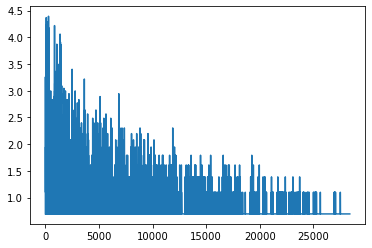

In [35]:
itempairs_by_session_basket1['Occurences_log'].plot()

In [36]:
### normalize occurences and occurences_log with max min normalization for clicks, basket, order
# clicks
itempairs_by_session_clicked1['Occurences'] = 0.9*((itempairs_by_session_clicked1['Occurences'] - itempairs_by_session_clicked1['Occurences'].min())/(itempairs_by_session_clicked1['Occurences'].max()- itempairs_by_session_clicked1['Occurences'].min()))+0.1
itempairs_by_session_clicked1['Occurences_log'] = 0.9*((itempairs_by_session_clicked1['Occurences_log'] - itempairs_by_session_clicked1['Occurences_log'].min())/(itempairs_by_session_clicked1['Occurences_log'].max()- itempairs_by_session_clicked1['Occurences_log'].min()))+0.1
# basket
itempairs_by_session_basket1['Occurences'] = 0.9*((itempairs_by_session_basket1['Occurences'] - itempairs_by_session_basket1['Occurences'].min())/(itempairs_by_session_basket1['Occurences'].max()- itempairs_by_session_basket1['Occurences'].min()))+0.1
itempairs_by_session_basket1['Occurences_log'] = 0.9*((itempairs_by_session_basket1['Occurences_log'] - itempairs_by_session_basket1['Occurences_log'].min())/(itempairs_by_session_basket1['Occurences_log'].max()- itempairs_by_session_basket1['Occurences_log'].min()))+0.1
# order
itempairs_by_session_ordered1['Occurences'] = 0.9*((itempairs_by_session_ordered1['Occurences'] - itempairs_by_session_ordered1['Occurences'].min())/(itempairs_by_session_ordered1['Occurences'].max()- itempairs_by_session_ordered1['Occurences'].min()))+0.1
itempairs_by_session_ordered1['Occurences_log'] = 0.9*((itempairs_by_session_ordered1['Occurences_log'] - itempairs_by_session_ordered1['Occurences_log'].min())/(itempairs_by_session_ordered1['Occurences_log'].max()- itempairs_by_session_ordered1['Occurences_log'].min()))+0.1


In [37]:
itempairs_by_session_ordered1.describe()

,Occurences,Element1,Element2,Occurences_log
count,5181.000000,5181.000000,5181.000000,5181.000000
mean,0.117105,27511.955993,53877.948852,0.136143
std,0.063259,18837.261886,18757.041664,0.108132
min,0.100000,54.000000,3259.000000,0.100000
25%,0.100000,12105.000000,41042.000000,0.100000
50%,0.100000,23978.000000,57594.000000,0.100000
75%,0.100000,41753.000000,70221.000000,0.100000
max,1.000000,78393.000000,79066.000000,1.000000


In [38]:
### append switched Element columns of "CLICKED"
# delete column "Pair"
itempairs_by_session_clicked1 = itempairs_by_session_clicked1.drop(columns= ['Pair'])

# copy itempairs_by_session_clicked1 --> switch element 1 and 2 and append to original dataframe
itempairs_by_session_clicked1_2 = itempairs_by_session_clicked1.copy()

# swap 2 columns
cols = list(itempairs_by_session_clicked1_2.columns)
a, b = cols.index('Element1'), cols.index('Element2')
cols[b], cols[a] = cols[a], cols[b]
itempairs_by_session_clicked1_2 = itempairs_by_session_clicked1_2[cols]

# rename columns
itempairs_by_session_clicked1_2 = itempairs_by_session_clicked1_2.rename(columns={'Element2':'Element21','Element1':'Element12'})
itempairs_by_session_clicked1_2 = itempairs_by_session_clicked1_2.rename(columns={'Element21':'Element1','Element12':'Element2'})

# append copied dataframe to original one
itempairs_by_session_clicked1 = itempairs_by_session_clicked1.append(itempairs_by_session_clicked1_2)

In [39]:
### append switched Element columns of "BASKET"
# delete column "Pair"
itempairs_by_session_basket1 = itempairs_by_session_basket1.drop(columns= ['Pair'])

# copy itempairs_by_session_clicked1 --> switch element 1 and 2 and append to original dataframe
itempairs_by_session_basket1_2 = itempairs_by_session_basket1.copy()

# swap 2 columns
cols = list(itempairs_by_session_basket1_2.columns)
a, b = cols.index('Element1'), cols.index('Element2')
cols[b], cols[a] = cols[a], cols[b]
itempairs_by_session_basket1_2 = itempairs_by_session_basket1_2[cols]

# rename columns
itempairs_by_session_basket1_2 = itempairs_by_session_basket1_2.rename(columns={'Element2':'Element21','Element1':'Element12'})
itempairs_by_session_basket1_2 = itempairs_by_session_basket1_2.rename(columns={'Element21':'Element1','Element12':'Element2'})

# append copied dataframe to original one
itempairs_by_session_basket1 = itempairs_by_session_basket1.append(itempairs_by_session_basket1_2)

In [40]:
### append switched Element columns of "ORDER"
# delete column "Pair"
itempairs_by_session_ordered1 = itempairs_by_session_ordered1.drop(columns= ['Pair'])

# copy itempairs_by_session_clicked1 --> switch element 1 and 2 and append to original dataframe
itempairs_by_session_ordered1_2 = itempairs_by_session_ordered1.copy()

# swap 2 columns
cols = list(itempairs_by_session_ordered1_2.columns)
a, b = cols.index('Element1'), cols.index('Element2')
cols[b], cols[a] = cols[a], cols[b]
itempairs_by_session_ordered1_2 = itempairs_by_session_ordered1_2[cols]

# rename columns
itempairs_by_session_ordered1_2 = itempairs_by_session_ordered1_2.rename(columns={'Element2':'Element21','Element1':'Element12'})
itempairs_by_session_ordered1_2 = itempairs_by_session_ordered1_2.rename(columns={'Element21':'Element1','Element12':'Element2'})

# append copied dataframe to original one
itempairs_by_session_ordered1 = itempairs_by_session_ordered1.append(itempairs_by_session_ordered1_2)

In [41]:
itempairs_by_session_clicked1

,Occurences,Element1,Element2,Occurences_log
0,0.116438,14576,17731,0.310148
1,0.100000,29508,30277,0.100000
2,0.100000,29508,75659,0.100000
3,0.104110,30277,75659,0.177559
4,0.100000,55699,62433,0.100000
...,...,...,...,...
292428,0.100000,50891,13996,0.100000
292429,0.100000,73084,13996,0.100000
292430,0.100000,73084,23084,0.100000
292431,0.100000,73084,50891,0.100000


In [42]:
# save to pickle file
#"""
with open('itempairs_by_session_clicked1.pkl', 'wb') as f:
    pickle.dump(itempairs_by_session_clicked1, f)
#"""

In [43]:
# save to pickle file
#"""
with open('itempairs_by_session_basket1.pkl', 'wb') as f:
    pickle.dump(itempairs_by_session_basket1, f)
#"""

In [44]:
# save to pickle file
#"""
with open('itempairs_by_session_ordered1.pkl', 'wb') as f:
    pickle.dump(itempairs_by_session_ordered1, f)
#"""

### transform dataframes into matrices -> don't need right now

In [45]:
items_clicked = itempairs_by_session_clicked1.pivot_table('Occurences', ['Element1'], 'Element2').fillna(0)
items_basket = itempairs_by_session_basket1.pivot_table('Occurences', ['Element1'], 'Element2').fillna(0)
items_ordered = itempairs_by_session_ordered1.pivot_table('Occurences', ['Element1'], 'Element2').fillna(0)

In [24]:
items_clicked.head()

Element2,370,382,395,598,606,615,616,676,695,762,...,78996,79014,79038,79043,79044,79051,79057,79058,79062,79066
Element1,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
items_basket.shape

(4925, 4943)

In [26]:
#combine different scores with meaningful weights -> come up with weights
dataexport = (items_clicked.add(items_basket,fill_value=0).add(items_ordered,fill_value=0) / 3)

In [27]:
dataexport[370].value_counts()

0.000000    12179
0.001522        1
Name: 370, dtype: int64

### Apriori Algorithm

In [40]:
#### ALREADY DONE ABOVE
### filter out items that are not needed
### for apriori, only sublists, that contain at least one element from evaluation set, are needed, others create rules that are not needed
#evaluation_list = list(evaluation['itemID'])
#itemgroups_ordered_filtered = [item_list for item_list in itemgroups_by_session_ordered1 if any(i in item_list for i in evaluation_list)==True]
#itemgroups_clicked_filtered = [item_list for item_list in itemgroups_by_session_clicked1 if any(i in item_list for i in evaluation_list)==True]
#itemgroups_basket_filtered = [item_list for item_list in itemgroups_by_session_basket1 if any(i in item_list for i in evaluation_list)==True]

In [195]:
# define minSup for apriori algorithm
minSup_order = 3/len(itemgroups_ordered_filtered)
minSup_basket = 5/len(itemgroups_basket_filtered)
minSup_clicked = 15/len(itemgroups_clicked_filtered)

#### apriori 'order'

In [196]:
# run apriori algorithm on 'order' 
freqItemSet_order, rules_order = apriori(itemgroups_ordered_filtered, minSup= minSup_order , minConf= minSup_order)

In [116]:
# load 'rules_order' from pickle
#with open('apriori_rules_order_minSup3.pkl', 'rb') as f:
#    rules_order = pickle.load(f)

In [222]:
freqItemSet_order

{1: {frozenset({40692}),
  frozenset({14314}),
  frozenset({70842}),
  frozenset({22764}),
  frozenset({70197}),
  frozenset({52146}),
  frozenset({64901}),
  frozenset({5739}),
  frozenset({69093}),
  frozenset({42715}),
  frozenset({25663}),
  frozenset({52355}),
  frozenset({10482}),
  frozenset({71747}),
  frozenset({74398}),
  frozenset({25971}),
  frozenset({11609}),
  frozenset({1136}),
  frozenset({4833}),
  frozenset({3259}),
  frozenset({45238}),
  frozenset({77255}),
  frozenset({45285}),
  frozenset({62060})},
 2: {frozenset({5739, 64901}),
  frozenset({4833, 22764}),
  frozenset({4833, 77255}),
  frozenset({14314, 25971}),
  frozenset({22764, 64901}),
  frozenset({14314, 77255}),
  frozenset({5739, 22764}),
  frozenset({10482, 69093}),
  frozenset({52355, 64901}),
  frozenset({4833, 52355}),
  frozenset({5739, 52355}),
  frozenset({1136, 62060}),
  frozenset({70197, 70842}),
  frozenset({3259, 40692}),
  frozenset({4833, 14314}),
  frozenset({22764, 52355}),
  frozenset({4

#### apriori 'basket'

In [198]:
# run apriori algorithm on 'basket'
freqItemSet_basket, rules_basket = apriori(itemgroups_basket_filtered, minSup= minSup_basket , minConf= minSup_basket)

In [118]:
# load 'rules_basket' from pickle
#with open('apriori_rules_basket_minSup5.pkl', 'rb') as f:
#    rules_basket = pickle.load(f)

#### apriori 'click'

In [200]:
# run apriori algorithm on 'click' --> long computing time
freqItemSet_click, rules_click = apriori(itemgroups_clicked_filtered, minSup= minSup_clicked , minConf= minSup_clicked)

In [201]:
# load 'rules_click' from pickle
#with open('apriori_rules_click_minSup15.pkl', 'rb') as f:
#    rules_click = pickle.load(f)

#### process apriori rules for use

In [203]:
### delete all rules that contain more than 1 element on left side of rule
rules_order_1elem = [i for i in rules_order if len(i[0])==1]
rules_basket_1elem = [i for i in rules_basket if len(i[0])==1]
rules_click_1elem = [i for i in rules_click if len(i[0])==1]

In [204]:
### check how long right side of rule is
#len(max(df_rules_click['recommendation'], key = len))

In [205]:
### save rules_order to dataframe
df_rules_order = pd.DataFrame(rules_order_1elem, columns=['item_ID', 'recommendation', 'rule_confidence'])

# structure dataframe for rules_order
df_rules_order[['item_ID']] = pd.DataFrame(df_rules_order.item_ID.tolist(), index= df_rules_order.index)
df_rules_order[['Recommendation1','Recommendation2', 'Recommendation3', 'Recommendation4']] = pd.DataFrame(df_rules_order.recommendation.tolist(), index= df_rules_order.index)
df_rules_order = df_rules_order.drop(columns=['recommendation'])

In [206]:
### save rules_basket to dataframe
df_rules_basket = pd.DataFrame(rules_basket_1elem, columns =['item_ID', 'recommendation', 'rule_confidence'])

# structure dataframe for rules_order
df_rules_basket[['item_ID']] = pd.DataFrame(df_rules_basket.item_ID.tolist(), index= df_rules_basket.index)
df_rules_basket[['Recommendation1','Recommendation2', 'Recommendation3', 'Recommendation4']] = pd.DataFrame(df_rules_basket.recommendation.tolist(), index= df_rules_basket.index)
df_rules_basket = df_rules_basket.drop(columns=['recommendation'])

In [207]:
### save rules_click to dataframe
df_rules_click = pd.DataFrame(rules_click_1elem, columns =['item_ID', 'recommendation', 'rule_confidence'])

# structure dataframe for rules_order
df_rules_click[['item_ID']] = pd.DataFrame(df_rules_click.item_ID.tolist(), index= df_rules_click.index)
df_rules_click[['Recommendation1','Recommendation2']] = pd.DataFrame(df_rules_click.recommendation.tolist(), index= df_rules_click.index)
df_rules_click = df_rules_click.drop(columns=['recommendation'])

In [208]:
# save to pickle file
#"""
with open('apriori_rules_order_minSup_3.pkl', 'wb') as f:
    pickle.dump(df_rules_order, f)
#""" 

In [209]:
# save to pickle file
#"""
with open('apriori_rules_basket_minSup_5.pkl', 'wb') as f:
    pickle.dump(df_rules_basket, f)
#""" 

In [210]:
# save to pickle file
#"""
with open('apriori_rules_click_minSup_15.pkl', 'wb') as f:
    pickle.dump(df_rules_click, f)
#""" 

#### write each item in a list into an own column -> not relevant right now

In [211]:
# for clicks:
itemgroups_by_session_clicked1_cols = pd.DataFrame(itemgroups_by_session_clicked1.tolist(), index= itemgroups_by_session_clicked1.index)
# for basket:
itemgroups_by_session_basket1_cols = pd.DataFrame(itemgroups_by_session_basket1.tolist(), index= itemgroups_by_session_basket1.index)
# for ordered: 
itemgroups_by_session_ordered1_cols = pd.DataFrame(itemgroups_by_session_ordered1.tolist(), index= itemgroups_by_session_ordered1.index)

### total occurences of book clicks / baskets / orders

In [212]:
tx_item_sums = tx.groupby('itemID').agg({'click':'sum', 'basket':'sum', 'order': 'sum'})

In [213]:
tx_item_sums.head()

,click,basket,order
itemID,,,
1,2,0,0
2,17,0,0
6,11,0,0
7,3,0,0
10,14,1,0


In [214]:
### apply log to get less skewed data
# click log
click_log = np.log(tx_item_sums.click + 1)
#click_log.describe()
# basket log
basket_log = np.log(tx_item_sums.basket + 1)
# order log
order_log = np.log(tx_item_sums.order + 1)

In [215]:
# add log cols to dataframe
tx_item_sums['click_log'] = click_log
tx_item_sums['basket_log'] = basket_log
tx_item_sums['order_log'] = order_log

In [216]:
tx_item_sums.order_log.describe()

count    24909.000000
mean         0.242591
std          0.553072
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.141664
Name: order_log, dtype: float64

In [217]:
# min max normalization
tx_item_sums_norm = (0.9*(tx_item_sums - tx_item_sums.min())/(tx_item_sums.max()-tx_item_sums.min()))+0.1

In [218]:
# mean normalization
#tx_item_sums_norm = (tx_item_sums - tx_item_sums.mean()) / tx_item_sums.std()

In [219]:
tx_item_sums_norm.describe()

,click,basket,order,click_log,basket_log,order_log
count,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000
mean,0.105039,0.103120,0.103756,0.304219,0.168430,0.142463
std,0.019336,0.015207,0.018291,0.135609,0.115702,0.096810
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
25%,0.100279,0.100000,0.100000,0.177205,0.100000,0.100000
50%,0.100836,0.100000,0.100000,0.254409,0.100000,0.100000
75%,0.103066,0.101508,0.100000,0.376776,0.197572,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [220]:
# save to pickle file
#"""
with open('df_total_occurences_norm.pkl', 'wb') as f:
    pickle.dump(tx_item_sums_norm, f)
#""" 